# Inclusion financière en Afrique

## 0. Préalable

### Importation des modules

In [49]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# splitting
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
# encoding
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler
# metrics
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

In [3]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement du jeu de données

In [23]:
DATA_PATH = 'data/' # repertoire des données
train = pd.read_csv(DATA_PATH + 'Train.csv') # ensemble d'apprentissage
test = pd.read_csv(DATA_PATH + 'Test.csv') # ensemble de test
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv') # exemple de soumission

In [24]:
train.head(4)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private


In [25]:
ID = 'uniqueid'
TARGET = 'bank_account'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

La target de notre dataset est la variable **bank_account**.

Dimension du dataset

In [26]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (23524, 13)
Dimension du test set : (10086, 12)


Types des variables

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Analyse des variables qualitatives

In [28]:
train.describe(include='object')

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_1,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


In [42]:
test.describe(include='object')

,country,uniqueid,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,10086,10086,10086,10086,10086,10086,10086,10086,10086
unique,4,7313,2,2,2,6,5,6,10
top,Rwanda,uniqueid_8633,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,3745,3,6189,7559,5847,5487,4663,5479,2773


In [29]:
for colonne in list(train.columns):
    print(train[colonne].value_counts(), '\n')

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: count, dtype: int64 

year
2016    8735
2018    8169
2017    6620
Name: count, dtype: int64 

uniqueid
uniqueid_1       4
uniqueid_1413    4
uniqueid_1411    4
uniqueid_1410    4
uniqueid_1409    4
                ..
uniqueid_7318    1
uniqueid_7317    1
uniqueid_7316    1
uniqueid_7315    1
uniqueid_8759    1
Name: count, Length: 8735, dtype: int64 

bank_account
No     20212
Yes     3312
Name: count, dtype: int64 

location_type
Rural    14343
Urban     9181
Name: count, dtype: int64 

cellphone_access
Yes    17454
No      6070
Name: count, dtype: int64 

household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: count, dtype: int64 

age_of_respondent
30     1056
35      836
25      792
28      748
32      715
       ... 
1

Analyse des variables quantitatives

In [30]:
train.describe(include='number')

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


Analyse des données manquantes

In [31]:
train.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

Super ! Notre dataset ne contient aucune donnée manquante.

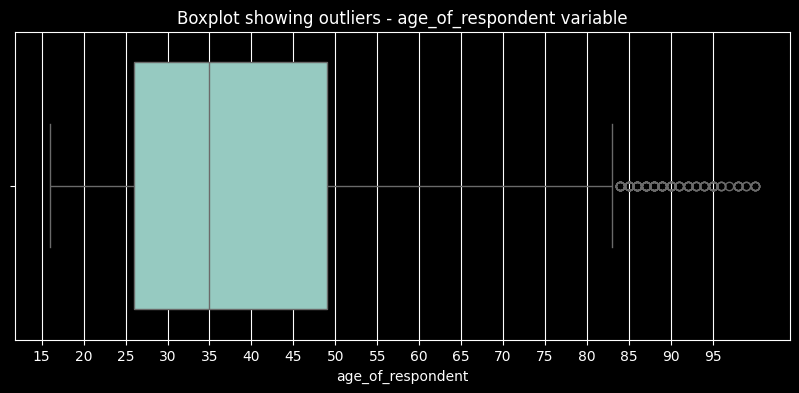

In [32]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
plt.grid()
plt.xticks(np.arange(0, 100, 5))
sns.boxplot(x=train['age_of_respondent'])
plt.title('Boxplot showing outliers - age_of_respondent variable')
plt.show()

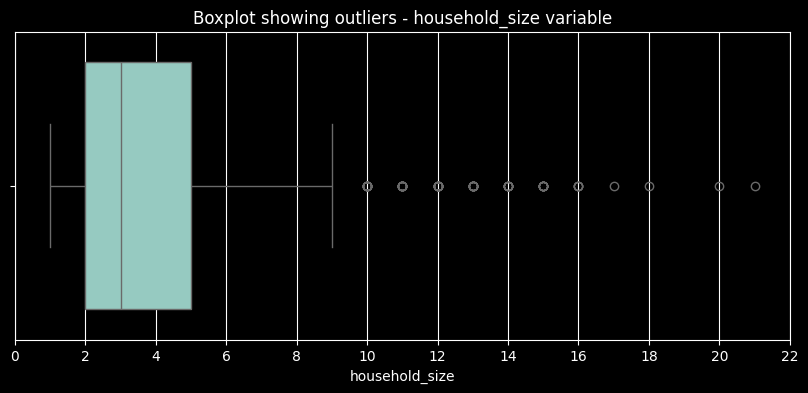

In [33]:
plt.figure(figsize=(10, 4))
plt.grid()
plt.xticks(np.arange(0, 30, 2))
sns.boxplot(x=train['household_size'])
plt.title('Boxplot showing outliers - household_size variable')
plt.show()

Il n'y a aucun outlier dans ce dataset.

### 1.2. Analyse du fond

Analyse et visualisation de la target (bank_account)

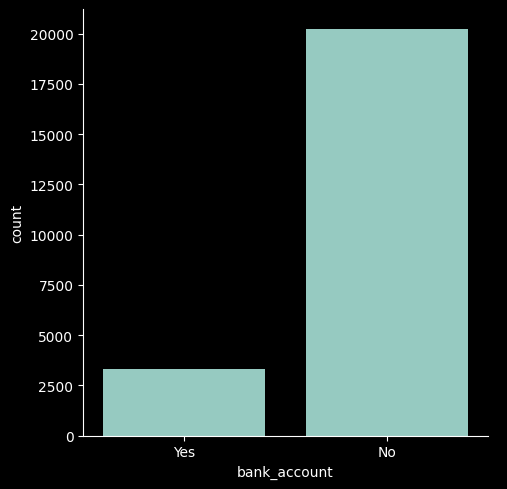

In [34]:
# explorons la distribution de la target
sns.catplot(data=train, x=TARGET, kind='count')
plt.show()

Matrice de corrélation de toutes les variables

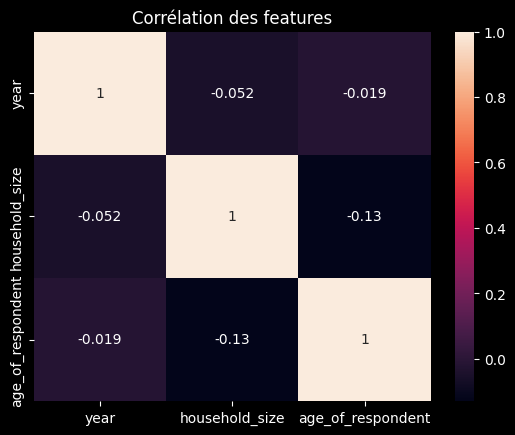

In [35]:
plt.title('Corrélation des features')
sns.heatmap(train.corr(numeric_only=True), annot=True)
plt.show()

00 corrélation entre les variables du dataset

## 2. Pré-traitement

### 2.1. Fonction réalisant le pré-traitement de notre dataset

#### Augmentation de variables

In [36]:
def is_employed(job):
    ''' 
    '''
    if job in ['Dont Know/Refuse to answer', 'Other Income']:
        return 'Other'
    elif job in ['Remittance Dependent', 'Government Dependent', 'Farming and Fishing', 'No Income']:
        return 'No'
    else:
        return 'Yes'


def has_been_married(status):
    ''' 
    '''
    if status in ['Dont know']:
        return 'Other'
    elif status in ['Single/Never Married']:
        return 'No'
    else:
        return 'Yes'


def id_educated(level):
    ''' 
    '''
    if level in ['Other/Dont know/RTA']:
        return 'Other'
    elif level in ['Vocational/Specialised training', 'No formal education']:
        return 'No'
    else:
        return 'Yes'


def id_head(relationship):
    ''' 
    '''
    if relationship in ['Head of Household']:
        return 'Yes'
    else:
        return 'No'

#### Dummification

In [59]:
# Instantiating the scalers
MMS = MinMaxScaler()

In [60]:
def processing_dummy(data: pd.DataFrame) -> pd.DataFrame:
    ''' preprocessing d'un dataframe avec la méthode de dummification
    '''
    try:
        data_dummy = pd.get_dummies(
            data.drop([ID, TARGET], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
        data_dummy[TARGET] = data[TARGET]
    except:
        data_dummy = pd.get_dummies(data.drop([ID], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
    try:
        # la liste des colonnes discrètes
        object_columns = list(
            data_dummy.select_dtypes(include='object').columns)
        # encodage des variables discrètes
        encoder = OrdinalEncoder()
        data_dummy[object_columns] = encoder.fit_transform(
            data_dummy[object_columns])
    except:
        pass
    return data_dummy

In [62]:
def ppa(df):
	data = df.copy()
	data['age_category'] = data['age_of_respondent'].apply(lambda x: str(x) if x < 84 else 'Vieux')
	data['household_category'] = data['household_size'].apply(lambda x: str(x) if x < 10 else 'Grand')
	data['has_been_married'] = data['marital_status'].apply(has_been_married)
	data['id_educated'] = data['education_level'].apply(id_educated)
	data['is_employed'] = data['job_type'].apply(is_employed)
	data['id_head'] = data['relationship_with_head'].apply(id_head)
	data = processing_dummy(data)

	cat_cols = data.select_dtypes(include='object').columns

	# Label encoding for other categorical columns
	le = LabelEncoder()
	for col in [col for col in cat_cols if col not in [ID]]:
		data[col] = le.fit_transform(data[col])
	
	return data

train_df = ppa(train)
test_df = ppa(test)

# Define features for modeling
features_for_modelling = [col for col in train_df.columns if col not in [ID, TARGET]]

print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")
train_df.head()

C:\Users\Juste Kouassi\AppData\Local\Temp\ipykernel_13796\4068179276.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_dummy[TARGET] = data[TARGET]


The shape of train_df is: (23524, 131)
The shape of test_df is: (10086, 130)
The shape of train is: (23524, 13)
The shape of test is: (10086, 12)
The features for modelling are:
['year', 'household_size', 'age_of_respondent', 'country_Kenya', 'country_Rwanda', 'country_Tanzania', 'country_Uganda', 'location_type_Rural', 'location_type_Urban', 'cellphone_access_No', 'cellphone_access_Yes', 'gender_of_respondent_Female', 'gender_of_respondent_Male', 'relationship_with_head_Child', 'relationship_with_head_Head of Household', 'relationship_with_head_Other non-relatives', 'relationship_with_head_Other relative', 'relationship_with_head_Parent', 'relationship_with_head_Spouse', 'marital_status_Divorced/Seperated', 'marital_status_Dont know', 'marital_status_Married/Living together', 'marital_status_Single/Never Married', 'marital_status_Widowed', 'education_level_No formal education', 'education_level_Other/Dont know/RTA', 'education_level_Primary education', 'education_level_Secondary educa

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,...,has_been_married_Yes,id_educated_No,id_educated_Other,id_educated_Yes,is_employed_No,is_employed_Other,is_employed_Yes,id_head_No,id_head_Yes,bank_account
0,1.0,0.10,0.095238,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,0.20,0.642857,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.20,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,1.0,0.20,0.214286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.35,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


### 2.2. Splitting pour l'entrainement

Séparation des features et de la target

In [63]:
# Create stratified train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df[features_for_modelling], 
    train_df[TARGET], 
    stratify=train_df[TARGET], 
    shuffle=True, 
	test_size=0.1,
    random_state=SEED
)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(21171, 130) (2353, 130) (21171,) (2353,)


## 3. Modélisation

### 3.1. Entrainement et score

[I 2024-12-28 22:17:35,213] A new study created in memory with name: no-name-dde9cdc6-de40-4fea-8fef-8e7b6ce0c1f7
[I 2024-12-28 22:17:49,829] Trial 0 finished with value: 0.16744581385465362 and parameters: {'booster': 'xgboost', 'random_state': 14, 'n_estimators': 1800, 'max_depth': 5, 'learning_rate': 0.09027563754603439, 'subsample': 0.9623989643295909, 'colsample_bytree': 0.7761574559996891, 'gamma': 0.23389863852440618, 'min_child_weight': 3}. Best is trial 0 with value: 0.16744581385465362.


[LightGBM] [Warning] feature_fraction is set=0.6435389606958922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435389606958922
[LightGBM] [Warning] lambda_l1 is set=0.8029779178869618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8029779178869618
[LightGBM] [Warning] lambda_l2 is set=0.35859522907378005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35859522907378005
[LightGBM] [Warning] bagging_fraction is set=0.7108553214327304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7108553214327304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6435389606958922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435389606958922
[LightGBM] [Warning] lambda_l1 is set=0.8029779178869618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8029779178869618
[LightGBM] [Warning] lambda_l2 is set=0.35859522907378005, reg_

[I 2024-12-28 22:17:54,777] Trial 1 finished with value: 0.09859753506162346 and parameters: {'booster': 'lightgbm', 'random_state': 10, 'n_estimators': 2600, 'max_depth': 9, 'learning_rate': 0.08115109225994364, 'num_leaves': 50, 'feature_fraction': 0.6435389606958922, 'bagging_fraction': 0.7108553214327304, 'lambda_l1': 0.8029779178869618, 'lambda_l2': 0.35859522907378005}. Best is trial 0 with value: 0.16744581385465362.


[LightGBM] [Warning] feature_fraction is set=0.6435389606958922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435389606958922
[LightGBM] [Warning] lambda_l1 is set=0.8029779178869618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8029779178869618
[LightGBM] [Warning] lambda_l2 is set=0.35859522907378005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35859522907378005
[LightGBM] [Warning] bagging_fraction is set=0.7108553214327304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7108553214327304


[I 2024-12-28 22:18:32,482] Trial 2 finished with value: 0.1529961750956226 and parameters: {'booster': 'xgboost', 'random_state': 1, 'n_estimators': 3000, 'max_depth': 8, 'learning_rate': 0.02011236612937393, 'subsample': 0.8053805518663868, 'colsample_bytree': 0.755964998336984, 'gamma': 0.1824789410812117, 'min_child_weight': 1}. Best is trial 0 with value: 0.16744581385465362.


[LightGBM] [Warning] feature_fraction is set=0.869215523065958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.869215523065958
[LightGBM] [Warning] lambda_l1 is set=0.9224024816537257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9224024816537257
[LightGBM] [Warning] lambda_l2 is set=0.853824095777402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.853824095777402
[LightGBM] [Warning] bagging_fraction is set=0.61793558798759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.61793558798759
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.869215523065958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.869215523065958
[LightGBM] [Warning] lambda_l1 is set=0.9224024816537257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9224024816537257
[LightGBM] [Warning] lambda_l2 is set=0.853824095777402, reg_lambda=0.0 wil

[I 2024-12-28 22:18:35,289] Trial 3 finished with value: 0.09987250318742032 and parameters: {'booster': 'lightgbm', 'random_state': 12, 'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.013083182822389131, 'num_leaves': 130, 'feature_fraction': 0.869215523065958, 'bagging_fraction': 0.61793558798759, 'lambda_l1': 0.9224024816537257, 'lambda_l2': 0.853824095777402}. Best is trial 0 with value: 0.16744581385465362.


[LightGBM] [Warning] feature_fraction is set=0.869215523065958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.869215523065958
[LightGBM] [Warning] lambda_l1 is set=0.9224024816537257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9224024816537257
[LightGBM] [Warning] lambda_l2 is set=0.853824095777402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.853824095777402
[LightGBM] [Warning] bagging_fraction is set=0.61793558798759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.61793558798759


[I 2024-12-28 22:18:38,463] Trial 4 finished with value: 0.20441988950276244 and parameters: {'booster': 'xgboost', 'random_state': 11, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.043651672981746666, 'subsample': 0.9599776870148791, 'colsample_bytree': 0.9918239897289405, 'gamma': 0.32968869344210605, 'min_child_weight': 2}. Best is trial 4 with value: 0.20441988950276244.
[I 2024-12-28 22:19:04,231] Trial 5 finished with value: 0.175945601359966 and parameters: {'booster': 'xgboost', 'random_state': 8, 'n_estimators': 2500, 'max_depth': 4, 'learning_rate': 0.07641530510356938, 'subsample': 0.9706076588199829, 'colsample_bytree': 0.7691609681441902, 'gamma': 0.3259168746942097, 'min_child_weight': 2}. Best is trial 4 with value: 0.20441988950276244.


0:	learn: 0.6559436	total: 39.5ms	remaining: 27.6s
300:	learn: 0.2474478	total: 12.6s	remaining: 16.8s
600:	learn: 0.2266199	total: 25.4s	remaining: 4.18s
699:	learn: 0.2209993	total: 30.1s	remaining: 0us


[I 2024-12-28 22:19:34,850] Trial 6 finished with value: 0.09902252443688908 and parameters: {'booster': 'catboost', 'random_state': 5, 'iterations': 700, 'depth': 9, 'learning_rate': 0.06599114372504532, 'l2_leaf_reg': 8.583286239010075, 'bagging_temperature': 0.3424002775640491, 'rsm': 0.7060463571197325}. Best is trial 4 with value: 0.20441988950276244.
[I 2024-12-28 22:20:25,741] Trial 7 finished with value: 0.1410964725881853 and parameters: {'booster': 'xgboost', 'random_state': 13, 'n_estimators': 2900, 'max_depth': 11, 'learning_rate': 0.021549993315714923, 'subsample': 0.8866749720744372, 'colsample_bytree': 0.7987077157903729, 'gamma': 0.0659863383049934, 'min_child_weight': 1}. Best is trial 4 with value: 0.20441988950276244.


0:	learn: 0.6701133	total: 23.9ms	remaining: 40.6s
300:	learn: 0.2599556	total: 7.56s	remaining: 35.1s
600:	learn: 0.2414505	total: 15.3s	remaining: 28s
900:	learn: 0.2276668	total: 22.8s	remaining: 20.2s
1200:	learn: 0.2166742	total: 30.5s	remaining: 12.7s
1500:	learn: 0.2065540	total: 38.2s	remaining: 5.06s
1699:	learn: 0.2005728	total: 44.1s	remaining: 0us


[I 2024-12-28 22:21:10,843] Trial 8 finished with value: 0.09817254568635785 and parameters: {'booster': 'catboost', 'random_state': 1, 'iterations': 1700, 'depth': 8, 'learning_rate': 0.038089180841996424, 'l2_leaf_reg': 2.8387896000865127, 'bagging_temperature': 0.13726467403916612, 'rsm': 0.42926118554839243}. Best is trial 4 with value: 0.20441988950276244.


0:	learn: 0.6487980	total: 10.7ms	remaining: 14s
300:	learn: 0.2762137	total: 3.44s	remaining: 11.4s
600:	learn: 0.2701672	total: 7.86s	remaining: 9.14s
900:	learn: 0.2660512	total: 15s	remaining: 6.66s
1200:	learn: 0.2627259	total: 20.6s	remaining: 1.69s
1299:	learn: 0.2615668	total: 24.1s	remaining: 0us


[I 2024-12-28 22:21:35,709] Trial 9 finished with value: 0.09944751381215469 and parameters: {'booster': 'catboost', 'random_state': 1, 'iterations': 1300, 'depth': 3, 'learning_rate': 0.07860449702129345, 'l2_leaf_reg': 4.765408275083059, 'bagging_temperature': 0.25767493442339146, 'rsm': 0.6400145420035535}. Best is trial 4 with value: 0.20441988950276244.
[I 2024-12-28 22:22:05,194] Trial 10 finished with value: 0.20399490012749683 and parameters: {'booster': 'xgboost', 'random_state': 6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.04929071045091728, 'subsample': 0.6400636741930606, 'colsample_bytree': 0.998163587514683, 'gamma': 0.4861497596184192, 'min_child_weight': 4}. Best is trial 4 with value: 0.20441988950276244.
[I 2024-12-28 22:22:16,253] Trial 11 finished with value: 0.2056948576285593 and parameters: {'booster': 'xgboost', 'random_state': 6, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.04206063897024739, 'subsample': 0.6271721663938546, 'colsample_

[LightGBM] [Warning] feature_fraction is set=0.9480481098322407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480481098322407
[LightGBM] [Warning] lambda_l1 is set=0.02698580402729156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02698580402729156
[LightGBM] [Warning] lambda_l2 is set=0.042605390890273376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042605390890273376
[LightGBM] [Warning] bagging_fraction is set=0.9996876178254631, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996876178254631
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9480481098322407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480481098322407
[LightGBM] [Warning] lambda_l1 is set=0.02698580402729156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02698580402729156
[LightGBM] [Warning] lambda_l2 is set=0.04260539089027337

[I 2024-12-28 22:25:34,927] Trial 15 finished with value: 0.09987250318742032 and parameters: {'booster': 'lightgbm', 'random_state': 11, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05671564404022121, 'num_leaves': 190, 'feature_fraction': 0.9480481098322407, 'bagging_fraction': 0.9996876178254631, 'lambda_l1': 0.02698580402729156, 'lambda_l2': 0.042605390890273376}. Best is trial 11 with value: 0.2056948576285593.
[I 2024-12-28 22:26:19,408] Trial 16 finished with value: 0.18954526136846578 and parameters: {'booster': 'xgboost', 'random_state': 15, 'n_estimators': 1400, 'max_depth': 4, 'learning_rate': 0.02914274860083751, 'subsample': 0.8634922621676897, 'colsample_bytree': 0.9088827037257159, 'gamma': 0.42283757826513096, 'min_child_weight': 2}. Best is trial 11 with value: 0.2056948576285593.
[I 2024-12-28 22:26:31,404] Trial 17 finished with value: 0.21376965575860604 and parameters: {'booster': 'xgboost', 'random_state': 4, 'n_estimators': 600, 'max_depth': 2, 'learni

[LightGBM] [Warning] feature_fraction is set=0.6741026727426989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6741026727426989
[LightGBM] [Warning] lambda_l1 is set=0.20590446892958358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20590446892958358
[LightGBM] [Warning] lambda_l2 is set=0.9552316351574118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9552316351574118
[LightGBM] [Warning] bagging_fraction is set=0.9184544700989529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184544700989529
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6741026727426989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6741026727426989
[LightGBM] [Warning] lambda_l1 is set=0.20590446892958358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20590446892958358
[LightGBM] [Warning] lambda_l2 is set=0.9552316351574118, reg

[I 2024-12-28 22:26:50,352] Trial 18 finished with value: 0.09859753506162346 and parameters: {'booster': 'lightgbm', 'random_state': 3, 'n_estimators': 1600, 'max_depth': 5, 'learning_rate': 0.006945306239712887, 'num_leaves': 30, 'feature_fraction': 0.6741026727426989, 'bagging_fraction': 0.9184544700989529, 'lambda_l1': 0.20590446892958358, 'lambda_l2': 0.9552316351574118}. Best is trial 17 with value: 0.21376965575860604.


[LightGBM] [Warning] feature_fraction is set=0.6741026727426989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6741026727426989
[LightGBM] [Warning] lambda_l1 is set=0.20590446892958358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20590446892958358
[LightGBM] [Warning] lambda_l2 is set=0.9552316351574118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9552316351574118
[LightGBM] [Warning] bagging_fraction is set=0.9184544700989529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9184544700989529
0:	learn: 0.6383713	total: 310ms	remaining: 14m 59s
300:	learn: 0.2054023	total: 1m 22s	remaining: 11m 56s
600:	learn: 0.1696418	total: 2m 27s	remaining: 9m 25s
900:	learn: 0.1466797	total: 3m 21s	remaining: 7m 27s
1200:	learn: 0.1302681	total: 4m 9s	remaining: 5m 52s
1500:	learn: 0.1176524	total: 5m 9s	remaining: 4m 48s
1800:	learn: 0.1075599	total: 6m 10s	remaining: 3m 46s
2100:	learn: 0.0994952	total: 7m 6s	remaining: 2m 42

[I 2024-12-28 22:36:19,639] Trial 19 finished with value: 0.11899702507437314 and parameters: {'booster': 'catboost', 'random_state': 3, 'iterations': 2900, 'depth': 12, 'learning_rate': 0.09771638467904672, 'l2_leaf_reg': 9.287905664813094, 'bagging_temperature': 0.9181622531643125, 'rsm': 0.8846239280093431}. Best is trial 17 with value: 0.21376965575860604.


Best Hyperparameters: {'booster': 'xgboost', 'random_state': 4, 'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.005932526737075845, 'subsample': 0.6932985393737067, 'colsample_bytree': 0.9086577161293918, 'gamma': 0.27071716775445764, 'min_child_weight': 4}
mean_absolute_error : 0.1118

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      2022
         1.0       0.89      0.24      0.37       331

    accuracy                           0.89      2353
   macro avg       0.89      0.62      0.66      2353
weighted avg       0.89      0.89      0.86      2353



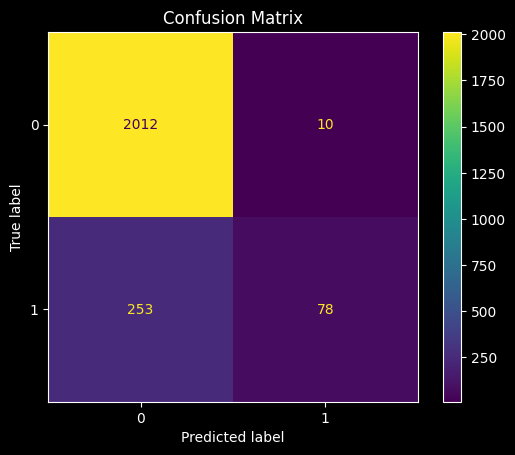

In [64]:
# Fonction objective pour Optuna
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Tries different boosting algorithms with various hyperparameters.
    """
    # Sélectionner le booster (modèle)
    booster = trial.suggest_categorical("booster", ["xgboost", "lightgbm", "catboost"])
    # booster = trial.suggest_categorical("booster", ["xgboost", "lightgbm"])
    seed = trial.suggest_int("random_state", 1, 15)

    if booster == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 2, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "random_state": seed,
            "scale_pos_weight": len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        }
        model = XGBClassifier(**params, eval_metric="logloss")

    elif booster == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 20, 200, step=10),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "random_state": seed,
        }
        model = LGBMClassifier(**params)

    elif booster == "catboost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 3000, step=100),
            "depth": trial.suggest_int("depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),
            "rsm": trial.suggest_float("rsm", 0.3, 0.9),
            "random_state": seed,
            "border_count": 128,
            "objective": "MultiClass",
            "early_stopping_rounds": 100,
            "verbose": 300
        }
        model = CatBoostClassifier(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_absolute_error(y_valid, y_pred)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
if best_params["booster"] == "xgboost":
    del best_params["booster"]
    final_model = XGBClassifier(**best_params, eval_metric="logloss")
elif best_params["booster"] == "lightgbm":
    final_model = LGBMClassifier(**best_params)
elif best_params["booster"] == "catboost":
    del best_params["booster"]
    final_model = CatBoostClassifier(**best_params, verbose=300)

# Train and evaluate final model
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_valid)

# Print model performance metrics
f1 = mean_absolute_error(y_valid, y_pred)
print(f"mean_absolute_error : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=final_model.classes_,
)
plt.title("Confusion Matrix")
plt.show()

Cette matrice montre que notre modèle reconnaît mieux les vrais négatifs (l'individu n'a pas de compte bancaire) par rapport aux vrais positifs (l'individu a un compte bancaire). Cela était prévisible car il y a 6 fois plus de négatifs que de positifs dans le dataset.

### 3.2. Compréhension du modèle

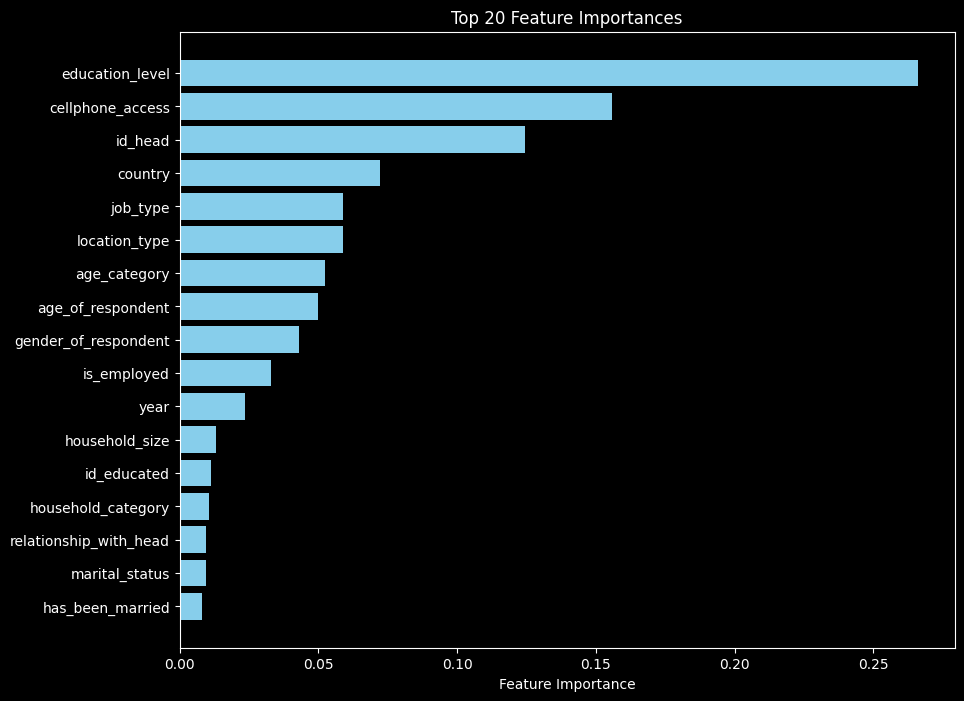

In [58]:
feature_importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

## 4. Prédiction et soumission

Après avoir choisi un modèle, réalisons maintenant les prédictions sur notre ensemble de test.

In [56]:
# Generate predictions for test set
test_predictions = final_model.predict(test_df[features_for_modelling])

# Create submission dataframe
test_df[TARGET] = test_predictions
sub = pd.DataFrame({"unique_id": test[ID] + " x " + test["country"], TARGET: test_df[TARGET].astype(int)})

# Save predictions to CSV file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
sub.to_csv(f'submissions/submission_{today}.csv', index=False)

sub.head()

,unique_id,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


## 5. Sauvegarde du modèle

In [ ]:
# Save the model as a pickle in a file
# joblib.dump(model_dummy, 'models/catboost_dummy_0.108665476.pkl')

: 